In [1]:
# https://www.ece.rice.edu/~wakin/images/
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy.stats import multivariate_normal
from skimage.measure import compare_psnr,compare_ssim

In [5]:
def mse(A,B):
    result= np.sum(np.square(np.subtract(A,B)))
    result1=np.sum(np.square(B))
    return result/result1
    

Image with size (512, 512) is taken as input
Image size of Decimated Input(64, 64)
216.0


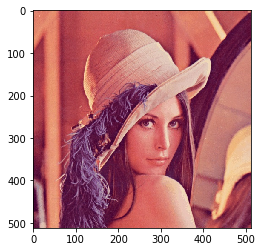

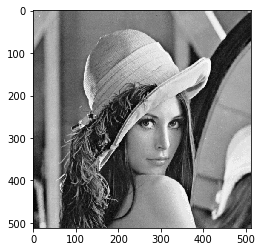

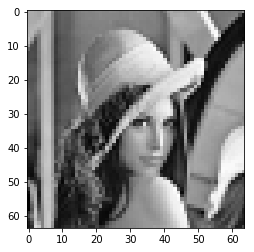

In [6]:
img=cv2.imread('../data/lena/lenargb.jpg',3)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)
img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(img,cmap='gray')

print ('Image with size ' + str(img.shape)+' is taken as input')
q=8
no_of_row = img.shape[0]
no_of_column = img.shape[1]
new_no_of_row = int(img.shape[0]/q)
new_no_of_column = int(img.shape[1]/q)

# Decimation Matrix
Dimg = np.zeros((new_no_of_row,new_no_of_column))
for i in range(new_no_of_row):
    for j in range(new_no_of_column):
        #Dimg[i,j]=int(np.mean(img[(q*i):(q*i+q),(q*j):(q*j+q)]))
        Dimg[i,j]=np.sum(img[(q*i):(q*i+q),(q*j):(q*j+q)])/(q*q)
print ('Image size of Decimated Input' + str(Dimg.shape))
plt.figure()
plt.imshow(Dimg,cmap="gray")
print(np.max(Dimg))

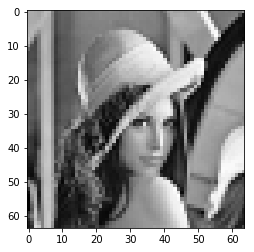

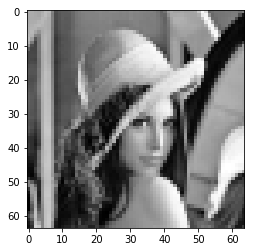

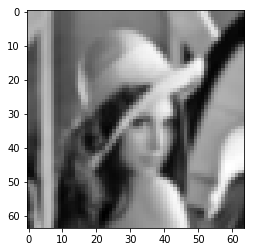

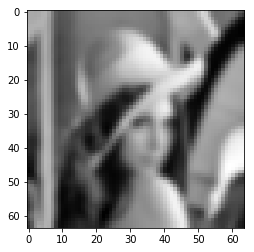

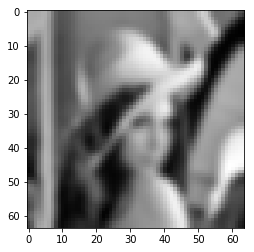

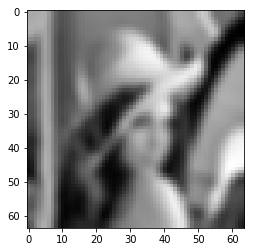

In [7]:
#Check this out for description of parameters
#https://www.tutorialkart.com/opencv/python/opencv-python-gaussian-image-smoothing/ 
plt.figure()
plt.imshow(Dimg, cmap="gray")

#parameters
no_of_lr_img = 5
Kernel_size=(5,5)
#sigma
sigma = np.array([0.4,0.7,1.0,1.2,1.5])


if sigma.shape[0]!=no_of_lr_img:
    print('length of sigma should be equal to no_of_lr_img')
HDimg = np.zeros((no_of_lr_img,Dimg.shape[0],Dimg.shape[1]))
for i in range(no_of_lr_img):
    HDimg[i,:,:] = cv2.GaussianBlur(Dimg,Kernel_size,sigma[i])
    plt.figure()
    plt.imshow(HDimg[i,:,:],cmap="gray")


# Blur
## Point Spread Function
- https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/VELDHUIZEN/node10.html#SECTION00522000000000000000
## Convolution to matrix-matrix multiplication
- https://stackoverflow.com/questions/16798888/2-d-convolution-as-a-matrix-matrix-multiplication
## Gaussian blur
- https://stackoverflow.com/questions/8204645/implementing-gaussian-blur-how-to-calculate-convolution-matrix-kernel

# ALL ABOUT GAUSSIAN KERNEL

In [8]:
#https://computergraphics.stackexchange.com/questions/39/how-is-gaussian-blur-implemented
#Gaussian Kernel Calculator
#http://dev.theomader.com/gaussian-kernel-calculator/
#Gaussian Blur Implemented
#https://www.codingame.com/playgrounds/2524/basic-image-manipulation/filtering

#just for dubugging
A = [[1,2],
    [3,4]]
B = [[1,2,5],
    [3,4,6]]
print(type(A))
print(type(B))
print(np.matmul(A,B))

# finding Gaussian Kernel kernel 
Kernel = cv2.getGaussianKernel(5,1)
A=Kernel
B=Kernel.transpose()
print(type(A))
print(type(B))
print(B)
print(np.matmul(A,B))

<class 'list'>
<class 'list'>
[[ 7 10 17]
 [15 22 39]]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[0.05448868 0.24420134 0.40261995 0.24420134 0.05448868]]
[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


# Gradient Descent

In [9]:
def cal_g_n(total_blurred_img,z2,row,col,Dpass,Hpass,HDzpass,ypass):
    G=np.zeros(z2.shape)
    lambda_smooth= 16.75  
#     print(G.shape)
    for k in range(row):
        for l in range(col):
            a = z2[(k*col)+l]
            b = 0 
            if l>=1:
                b = z2[(k*col)+l-1]
            c = 0 
            if l<col-1:
                c = z2[(k*col)+l+1]
            d = 0 
            if k>=1:
                d = z2[((k-1)*col)+l]
            e = 0 
            if k<row-1:
                e = z2[((k+1)*col)+l]

            G[(k*col)+l] = 2*(4*a-b-c-d-e)

    # G/lambda         
    G_by_lambda = G/lambda_smooth

    t = np.zeros(G.shape[0])
#     for i in range(total_blurred_img):
#     print('term t size '+str(t.shape))
#     print('fun upper '+' '+str(G_by_lambda.shape)+' '+str(z2.shape))
    for i in range(total_blurred_img):
#         print('For g, calculation of blurred image no '+str(i))
        t1=HDzpass[i,:,0]-ypass[i,:,0]
#         print('term 1 size '+str(t1.shape))
        t2=np.matmul(Hpass[i,:].transpose(),t1)
#         print('term 2 size '+str(t2.shape))
        t3=np.matmul(Dpass.transpose(),t2)
#         print('term 3 size '+str(t3.shape))
        t = t +t3
#         print('term t size '+str(t.shape))
    sigma_n=5
    t = t/(sigma_n*sigma_n)
#     print('term t size '+str(t.shape))
    t = t.reshape(t.shape[0],1)
#     print(t.shape)
    g_n = t + G_by_lambda
#     print('fun '+str(g_n.shape)+' '+str(G_by_lambda.shape)+' '+str(t.shape))
    return g_n

# Generation of D
## size of D is M1M2 * qqM1M2

Image with size (256, 256) is taken as input
Size of D 16384 65536
Size of 1D array (65536, 1) number of column in D 65536


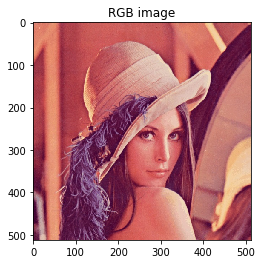

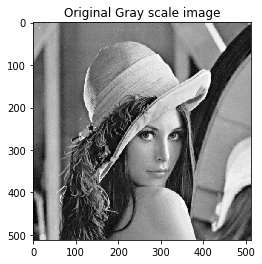

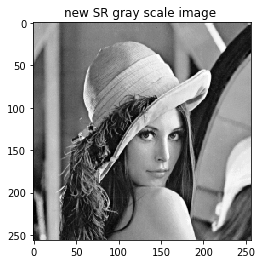

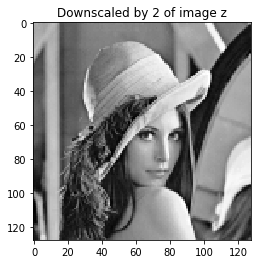

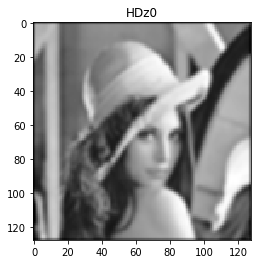

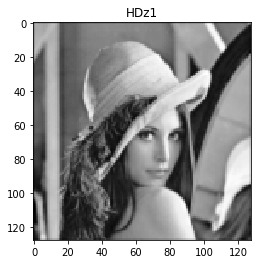

In [10]:
## image read
img=cv2.imread('../data/lena/lenargb.jpg',3)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.figure()
plt.title('RGB image')
plt.imshow(img)
img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.figure()
plt.title('Original Gray scale image')
plt.imshow(img,cmap='gray')


## creating new z (superresolved image)
q=2 #increase this parameter by multiplying two if there is memory error 
no_of_row = img.shape[0]
no_of_column = img.shape[1]
new_no_of_row = int(img.shape[0]/q)
new_no_of_column = int(img.shape[1]/q)
timg = np.zeros((new_no_of_row,new_no_of_column))
for i in range(new_no_of_row):
    for j in range(new_no_of_column):
        #Dimg[i,j]=int(np.mean(img[(q*i):(q*i+q),(q*j):(q*j+q)]))
        timg[i,j]=np.sum(img[(q*i):(q*i+q),(q*j):(q*j+q)])/(q*q)
img=timg    



## finding D
q=2 # downscaling factor
print ('Image with size ' + str(img.shape)+' is taken as input')
no_of_row = img.shape[0]
no_of_column = img.shape[1]
new_no_of_row = int(img.shape[0]/q)
new_no_of_column = int(img.shape[1]/q)

D = np.zeros((new_no_of_row*new_no_of_column,no_of_row*no_of_column))
print('Size of D '+str(D.shape[0])+' '+str(D.shape[1]))

for i in range(new_no_of_row):
    for j in range(new_no_of_column):
        for k in range(q):
            for l in range(q):
                try:
                    D[i*new_no_of_column+j,i*q*no_of_column+j*q+k*no_of_column+l]=1
                except:
                    print('error to excess this element '+str(i)+' '+str(j)+' '+str(k))
            
          
        
## Print D

# for i in range(D.shape[0]):
#     outp=''
#     for j in range(D.shape[1]):
#         outp=outp+str(int(D[i,j]))+' '
#     print(outp)
#     print('***********')

## creating vector image z
rows,cols = img.shape # gives dimensions for RGB array
img_size = (rows*cols,1)
z = img.reshape(img_size)
print('Size of 1D array '+str(z.shape)+' number of column in D '+str(new_no_of_row*new_no_of_column*q*q))

## Reshaped original image printed
img2 = z.reshape(rows,cols)
plt.figure()
plt.title('new SR gray scale image ')
plt.imshow(img2,cmap='gray')

#multiplying D and z 
Dz = np.matmul(D,z)
Dz = Dz/(q*q)
plt.figure()
plt.title('Downscaled by '+str(q)+' of image z')
plt.imshow(Dz.reshape(new_no_of_row,new_no_of_column),cmap='gray')


## finding H
no_of_blurred_image = 2
kernel_size=5
#sigma = np.zeros((no_of_blurred_image,1))
# count = 0
H = np.zeros((no_of_blurred_image,new_no_of_column*new_no_of_row,new_no_of_column*new_no_of_row))
    
for w in range(no_of_blurred_image):
    sigma = np.array([0.0,0.5])
    Kernel = cv2.getGaussianKernel(kernel_size,sigma[w])
    A=Kernel
    B=Kernel.transpose()
    Kernel=np.matmul(A,B)
    
    for i in range(new_no_of_row):
        for j in range(new_no_of_column):
            for k in range(kernel_size):
                halfkernelsize=math.floor(kernel_size/2)
                for l in range(kernel_size):
#                     H[i*new_no_of_column+j,1]=1
#                     print(Kernel[k,l])
                    try:
                        if (i-halfkernelsize+k)>=0 and (j-halfkernelsize+l)>=0 and (j-halfkernelsize+l)<new_no_of_column and (i-halfkernelsize+k)<new_no_of_row:
#                             print('hahaha')
                            H[w,i*new_no_of_column+j,(i-halfkernelsize+k)*new_no_of_column+(j-halfkernelsize+l)]=Kernel[k,l]
                    except:
                        print(str(i)+' '+str(j)+' '+str(k)+' '+str(l))
    # print Kernel
#     print(Kernel)
    # print matrix H
#     for i in range(new_no_of_column*new_no_of_row):
#         outp=''
#         for j in range(new_no_of_column*new_no_of_row):
#             outp=outp+str(int(H[w,i,j]))+' '
#         print(outp)
#     print('***********')
        

    
HDz = np.zeros((no_of_blurred_image, new_no_of_row*new_no_of_column,1))
for i in range(no_of_blurred_image):
    HDz[i,:,:] = np.matmul(H[i,:,:],Dz)
    timg2=HDz[i,:,:]
    timg2 = timg2.reshape(new_no_of_row,new_no_of_column)
    plt.figure()
    plt.title('HDz'+str(i))
    plt.imshow(timg2,cmap='gray')

In [26]:
D

array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [25]:
H

array([[[1.40625000e-01, 9.37500000e-02, 2.34375000e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.37500000e-02, 1.40625000e-01, 9.37500000e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.34375000e-02, 9.37500000e-02, 1.40625000e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.40625000e-01, 9.37500000e-02, 2.34375000e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         9.37500000e-02, 1.40625000e-01, 9.37500000e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.34375000e-02, 9.37500000e-02, 1.40625000e-01]],

       [[6.18693507e-01, 8.37310610e-02, 2.07548550e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.37310610e-02, 6.18693507e-01, 8.37310610e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.07548550e-04, 

## Addition of Noise & Gradient Descent optimization


(2, 16384, 1)
15968.709515890709 15968.709515890707 [3917975.01144977]
15968.709515890705 15968.709515890707 [3917975.01144977]
26.0
25.189819112613446
Initial MSE 0.00492098640460164
Initial PSNR 28.995983086439395
After Gradient Desecent MSE 0.004835873038126671
After Gradient Desecent PSNR 29.071755835439994
After Gradient Desecent MSE 0.00475453384372827
After Gradient Desecent PSNR 29.145425306968214


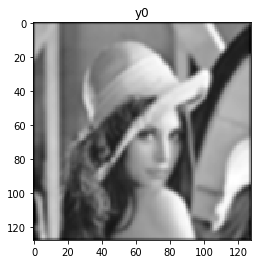

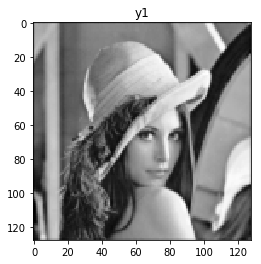

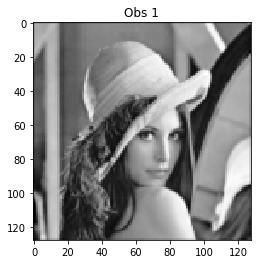

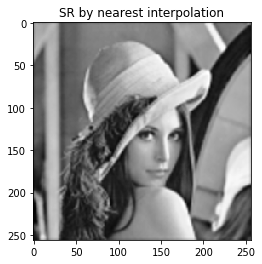

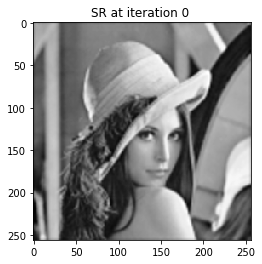

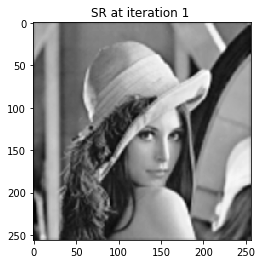

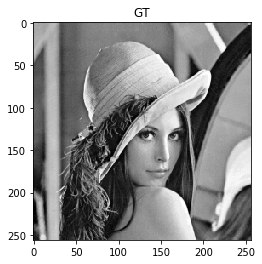

In [20]:
#noise addition
print(HDz.shape)
x = np.linspace(-5, 5, new_no_of_column*new_no_of_row, endpoint=False)
noise = multivariate_normal.pdf(x, mean=0, cov=5.0)*10
#plt.figure()
#plt.plot(x,noise)
#plt.imshow()
y=HDz.copy()
for i in range(no_of_blurred_image):
    y[i,:,0]=HDz[i,:,0]+noise
    print(str(sum(y[i,:,0]-HDz[i,:,0]))+' '+str(sum(noise))+' '+str(sum(sum(HDz))))
    plt.figure()
    t = y[i,:]
    t = t.reshape(new_no_of_row,new_no_of_column)
    plt.title('y'+str(i))
    plt.imshow(t,cmap='gray')

#for displaying one of the observation with blurr    
_2d_y = y[1,:].reshape((new_no_of_row, new_no_of_column))
plt.figure()
plt.title('Obs 1')
plt.imshow(_2d_y, cmap='gray')

outsize = (no_of_row, no_of_column)
z1=cv2.resize(_2d_y,outsize,interpolation=cv2.INTER_CUBIC)
z1 = z1.reshape(((outsize[0] * outsize[1]),1))
print(np.min(z))
print(np.min(z1))
m = mse(z1, z)
print('Initial MSE '+str(m))
m = compare_psnr(z, z1,data_range=256)
print('Initial PSNR '+str(m))
t = z1.reshape(no_of_row,no_of_column)
plt.figure()
plt.title('SR by nearest interpolation')
plt.imshow(t, cmap='gray')
alpha = 0.1

#gradient descent optimization
for i in range(20):
#     print('Iteration '+str(i)) 
    z_new = z1 + alpha*cal_g_n(no_of_blurred_image, z1,no_of_row, no_of_column, D, H, HDz, y)
#     print(str(z_new.shape)+' '+str(no_of_row)+' '+str(no_of_column)+' '+str(q))
    alpha = alpha*0.99
    if i==1    
    
    
    '
    or i%100 == 0:
        t = z_new.reshape(no_of_row,no_of_column)
        plt.figure()
        plt.title('SR at iteration '+str(i)+' ')
        plt.imshow(t,cmap='gray')
        m = mse(z_new, z)
        print('After Gradient Desecent MSE '+str(m))
        m = compare_psnr(z, z_new,data_range=256)
        print('After Gradient Desecent PSNR '+str(m))
    z1 = z_new.copy()
plt.figure()
plt.title('GT')
plt.imshow(z.reshape(no_of_row,no_of_column), cmap='gray')

# - operation


(2, 16384, 1)
15968.709515890709 15968.709515890707 [3917975.01144977]
15968.709515890705 15968.709515890707 [3917975.01144977]
26.0
26.871178464205002
Initial MSE 0.006570593204602281
Initial PSNR 27.740458936453173
After Gradient Desecent MSE 0.006528520050217099
After Gradient Desecent PSNR 27.768357315930704
After Gradient Desecent MSE 0.006502347126725871
After Gradient Desecent PSNR 27.78580323319542
After Gradient Desecent MSE 0.006490167102745588
After Gradient Desecent PSNR 27.79394595085617
After Gradient Desecent MSE 0.006490299901515081
After Gradient Desecent PSNR 27.793857088455802
After Gradient Desecent MSE 0.006501263759709508
After Gradient Desecent PSNR 27.78652687883859
After Gradient Desecent MSE 0.0065217502698358435
After Gradient Desecent PSNR 27.772863090071613
After Gradient Desecent MSE 0.006550602812332561
After Gradient Desecent PSNR 27.753692065140072
After Gradient Desecent MSE 0.00658679787934756
After Gradient Desecent PSNR 27.72976136831626
After Gradi

C:\Users\Admin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


After Gradient Desecent MSE 0.007122302553010201
After Gradient Desecent PSNR 27.3903005542441
After Gradient Desecent MSE 0.00719561332246806
After Gradient Desecent PSNR 27.34582656633593
After Gradient Desecent MSE 0.007270356791845559
After Gradient Desecent PSNR 27.300947495084916
After Gradient Desecent MSE 0.007346283108531447
After Gradient Desecent PSNR 27.255828128144792


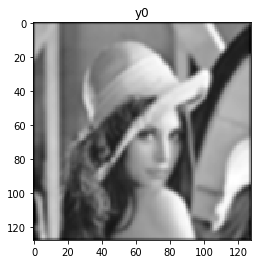

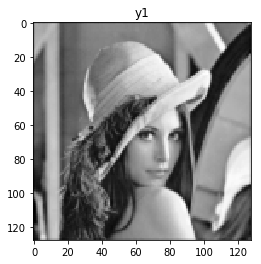

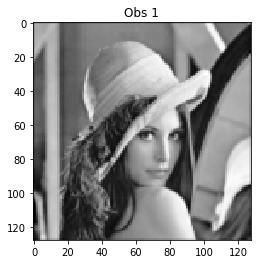

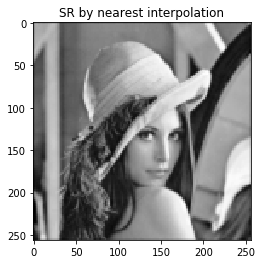

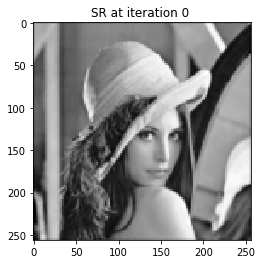

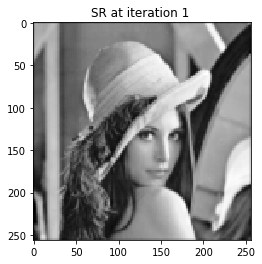

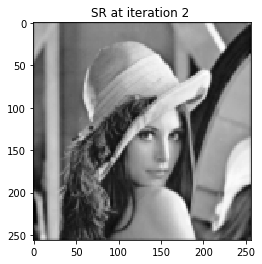

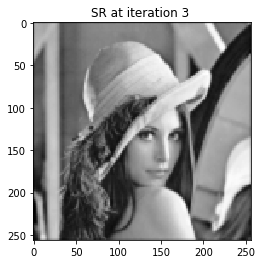

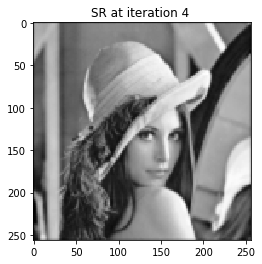

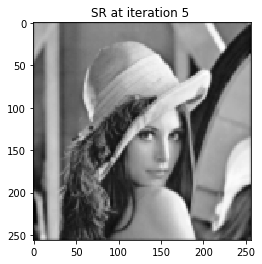

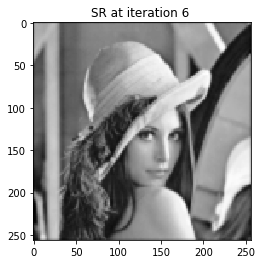

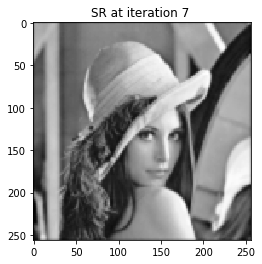

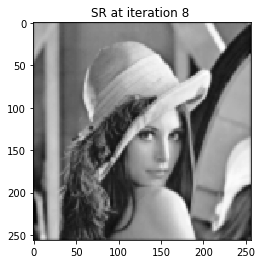

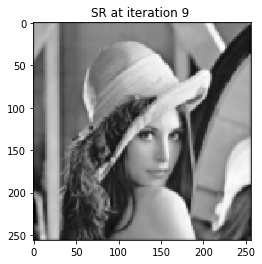

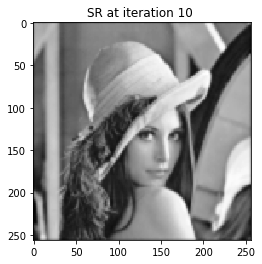

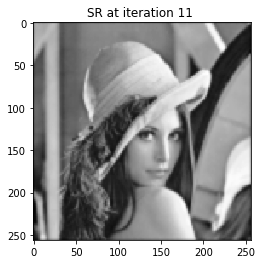

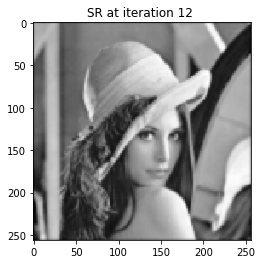

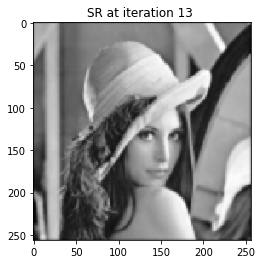

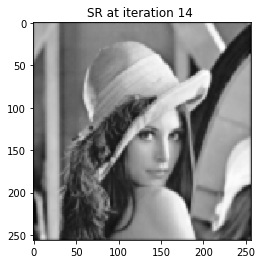

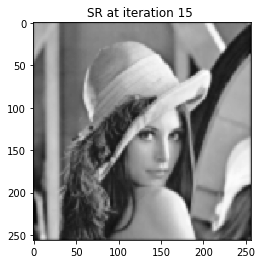

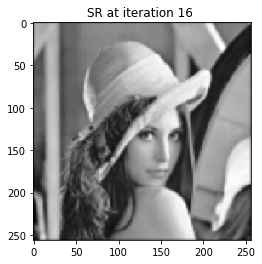

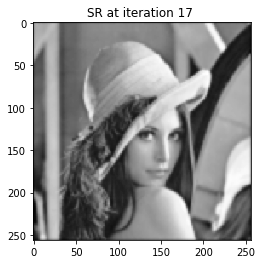

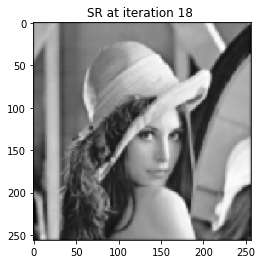

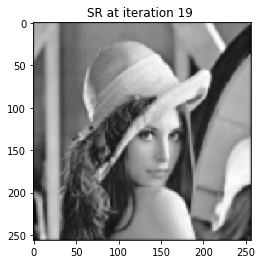

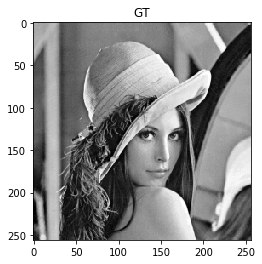

In [19]:
#noise addition
print(HDz.shape)
x = np.linspace(-5, 5, new_no_of_column*new_no_of_row, endpoint=False)
noise = multivariate_normal.pdf(x, mean=0, cov=5.0)*10
#plt.figure()
#plt.plot(x,noise)
#plt.imshow()
y=HDz.copy()
for i in range(no_of_blurred_image):
    y[i,:,0]=HDz[i,:,0]+noise
    print(str(sum(y[i,:,0]-HDz[i,:,0]))+' '+str(sum(noise))+' '+str(sum(sum(HDz))))
    plt.figure()
    t = y[i,:]
    t = t.reshape(new_no_of_row,new_no_of_column)
    plt.title('y'+str(i))
    plt.imshow(t,cmap='gray')

#for displaying one of the observation with blurr    
_2d_y = y[1,:].reshape((new_no_of_row, new_no_of_column))
plt.figure()
plt.title('Obs 1')
plt.imshow(_2d_y, cmap='gray')

outsize = (no_of_row, no_of_column)
z1=cv2.resize(_2d_y,outsize,interpolation=cv2.INTER_NEAREST)
z1 = z1.reshape(((outsize[0] * outsize[1]),1))
print(np.min(z))
print(np.min(z1))
m = mse(z1, z)
print('Initial MSE '+str(m))
m = compare_psnr(z, z1,data_range=256)
print('Initial PSNR '+str(m))
t = z1.reshape(no_of_row,no_of_column)
plt.figure()
plt.title('SR by nearest interpolation')
plt.imshow(t, cmap='gray')
alpha = 0.1

#gradient descent optimization

for i in range(20):
#     print('Iteration '+str(i))
    z_new = z1 - alpha*cal_g_n(no_of_blurred_image, z1,no_of_row, no_of_column, D, H, HDz, y)
#     print(str(z_new.shape)+' '+str(no_of_row)+' '+str(no_of_column)+' '+str(q))
    alpha = alpha*0.99
    if i%1 == 0 or i == 19:
        t = z_new.reshape(no_of_row,no_of_column)
        plt.figure()
        plt.title('SR at iteration '+str(i)+' ')
        plt.imshow(t,cmap='gray')
        m = mse(z_new, z)
        print('After Gradient Desecent MSE '+str(m))
        m = compare_psnr(z, z_new,data_range=256)
        print('After Gradient Desecent PSNR '+str(m))
    z1 = z_new.copy()
plt.figure()
plt.title('GT')
plt.imshow(z.reshape(no_of_row,no_of_column), cmap='gray')